# Objectives

1. Estimate Clock Model
1. Filter Outliers
    - Plot Prune Compare: Divtree
    - Plot Prune Compare: Timetree
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [1]:
# Bio
import treetime
from Bio import Phylo,AlignIO, Align,SeqIO
from ete3 import Tree

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys
import shutil

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "clock"
PREV_DIR_NAME = "parse_tree"
PREV_SCRIPT_NAME = "parse_tree"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "50"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "name"

## Paths

In [3]:
results_dir = os.path.join(project_dir, "results")
config_dir = os.path.join(results_dir, "config")


outdir       = os.path.join(results_dir, SCRIPT_NAME,   READS_ORIGIN, LOCUS_NAME, "filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME, "filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".phylo.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME, "filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME, "filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi", READS_ORIGIN, LOCUS_NAME, "filter{}".format(MISSING_DATA), "snippy-multi.snps.aln")


# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME, "filter{}".format(MISSING_DATA), "parse_tree" + "_lat-lon_auspice.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME, "filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

constant_sites_path = os.path.join(results_dir,"snippy_multi",READS_ORIGIN, LOCUS_NAME, "snippy-multi.full.constant_sites.txt")


print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "clock_model"

tree_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome/filter50/parse_tree.phylo.obj
tree_df_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome/filter50/parse_tree.df.obj
aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/chromosome/filter50/snippy-multi.snps.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome/filter50/parse_tree_lat-lon_auspice.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome/filter50/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome/filter50


## Import Tree

In [4]:
with open(tree_dill, "rb") as infile:
    tree = dill.load(infile)
tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,ufboot,scf,branch_length,node_type,coord_x,coord_y,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent
name,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,internal,0.000000,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Reference,NA,NA,1.153650e-05,terminal,0.000012,1.00,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,North America
NODE1,NA,NA,1.153650e-05,internal,0.000012,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,terminal,0.000036,2.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe
NODE2,NA,NA,2.721210e-05,internal,0.000039,5.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN02442718,NA,NA,2.330000e-08,terminal,0.000043,5.00,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: SRA Ancient,0,Europe
testlocal1,NA,NA,2.330000e-08,terminal,0.000043,6.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,testlocal1,KEEP: Local Test,NA,NA
NODE6,NA,NA,7.052000e-07,internal,0.000044,7.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Import Constant Sites

In [6]:
with open(constant_sites_path, "r") as infile:
    constant_sites_str = infile.read().strip().split(",")
    constant_sites_list = [int(c) for c in constant_sites_str]
    constant_sites = sum(constant_sites_list)
    constant_sites_freq = [c/constant_sites for c in constant_sites_list]
    fixed_pi = np.array(constant_sites_freq)
print(fixed_pi)

[0.26267549 0.23640246 0.23897306 0.26194899]


# 1. Filter Outlier Tips

## Parse Tip Dates

In [7]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v


Attempting to parse dates...
	Using column 'name' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.


---
# 1. Estimate Clock Model

## Initialize treetime object

In [8]:
tt = treetime.TreeTime(
    dates=dates,
    aln=aln_path,
    tree=tree,
    verbose=4,
    fill_overhangs=False,
    seq_len=REF_LEN,
    alphabet="nuc_nogap",
)


0.00	-TreeAnc: set-up

0.04	-SequenceData: loaded alignment.
0.04	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

0.04	-SeqData: making compressed alignment...

1.19	-SequenceData: constructed compressed alignment...
1.26	--ClockTree: Setting precision to level 2

1.26	-ClockTree._assign_dates: assigned date contraints to 6 out of 8 tips.


## Estimate the clock model

In [9]:
tt.run(
    infer_gtr=True,
    relaxed_clock={"slack" : 0.1, "coupling": 0},
    branch_length_mode = "joint", # joint or marginal
    # Testing
    time_marginal=True,   # True, False or "assign" 
    Tc="skyline",
    n_iqd=2,    
    max_iter=5,
    root=None,    
    fixed_pi=fixed_pi,
    resolve_polytomies=True,    
    use_covariation=False,    
    vary_rate=False,    
)

# Order nodes
tt.tree.ladderize(reverse=False)

# Add extra length to root
tt_orig = copy.deepcopy(tt)


1.27	-TreeAnc.optimize_tree: sequences...

1.27	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

1.27	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
1.27	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
1.27	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
1.28	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
    	   likelihood sequences...
1.29	---TreeAnc._ml_anc_joint: ...done
1.29	--TreeAnc.infer_gtr: counting mutations...
1.30	---TreeAnc.infer_gtr: counting mutations...done

1.30	-GTR: with alphabet: ['A', 'C', 'G', 'T']
1.30	--GTR: ambiguous character: N
1.30	----GTR: no gap symbol!
1.30	---GTR: ini

11.10	--Coalescent:optimize_skyline:...done. new LH: 77.417050
11.10	--optimized a skyline
relaxed_clock {'slack': 0.1, 'coupling': 0}
11.12	--TreeTime.relaxed_clock: slack=0.100000, coupling=0.000000

11.12	-TreeTime.resolve_polytomies: resolving multiple mergers...
11.12	---TreeTime.resolve_polytomies: No more polytomies to resolve

11.12	-ClockTree: Maximum likelihood tree optimization with temporal constraints
11.12	--ClockTree.init_date_constraints...
11.12	---ClockTree.init_date_constraints: Initializing branch length
     	   interpolation objects...
11.48	--ClockTree.date2dist: Setting new molecular clock. rate=-7.496e-09,
     	  R^2=0.3396
11.48	--ClockTree - Joint reconstruction:  Propagating leaves -> root...
12.75	--ClockTree - Joint reconstruction:  Propagating root -> leaves...

12.76	-TreeAnc.infer_ancestral_sequences with method: ml, joint
12.76	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
12.76	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelih

In [10]:
# Save the tracelog

trace_log = os.path.joinos.getcwd(), "trace_run.log")
out_path_trace_log = os.path.join(outdir, SCRIPT_NAME + "_trace_run.log") 
shutil.copyfile(trace_log, out_path_trace_log)

'/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome/filter50/clock_model_trace_run.log'

In [11]:
#tt = copy.deepcopy(tt_orig)

## Quick Checks

In [12]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.001, clock_length=0.001, comment='&ufboot=NA,scf=NA,branch_length=0.0,node_type=internal,co...', date='-1350-01-07', dist2root=0.0, mutation_length=0.001, name='NODE0', original_length=0.0)

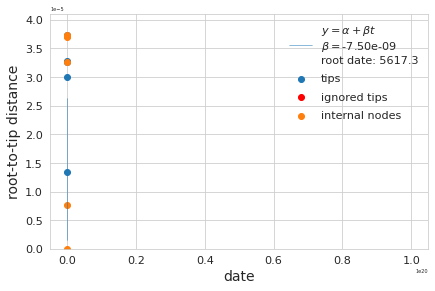

In [13]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [14]:
print(tt.gtr)

Substitution rate (mu): 1.0

Equilibrium frequencies (pi_i):
  A: 0.2627
  C: 0.2364
  G: 0.239
  T: 0.2619

Symmetrized rates from j->i (W_ij):
	A	C	G	T
  A	0	0.9953	2.5503	0.3491
  C	0.9953	0	0.3129	2.6277
  G	2.5503	0.3129	0	1.1771
  T	0.3491	2.6277	1.1771	0

Actual rates from j->i (Q_ij):
	A	C	G	T
  A	0	0.2615	0.6699	0.0917
  C	0.2353	0	0.074	0.6212
  G	0.6094	0.0748	0	0.2813
  T	0.0914	0.6883	0.3084	0



# 2. Filter Outliers

## Prune 'Bad' Branches from Divergence Tree

PRUNING: testlocal1
PRUNING: testlocal2


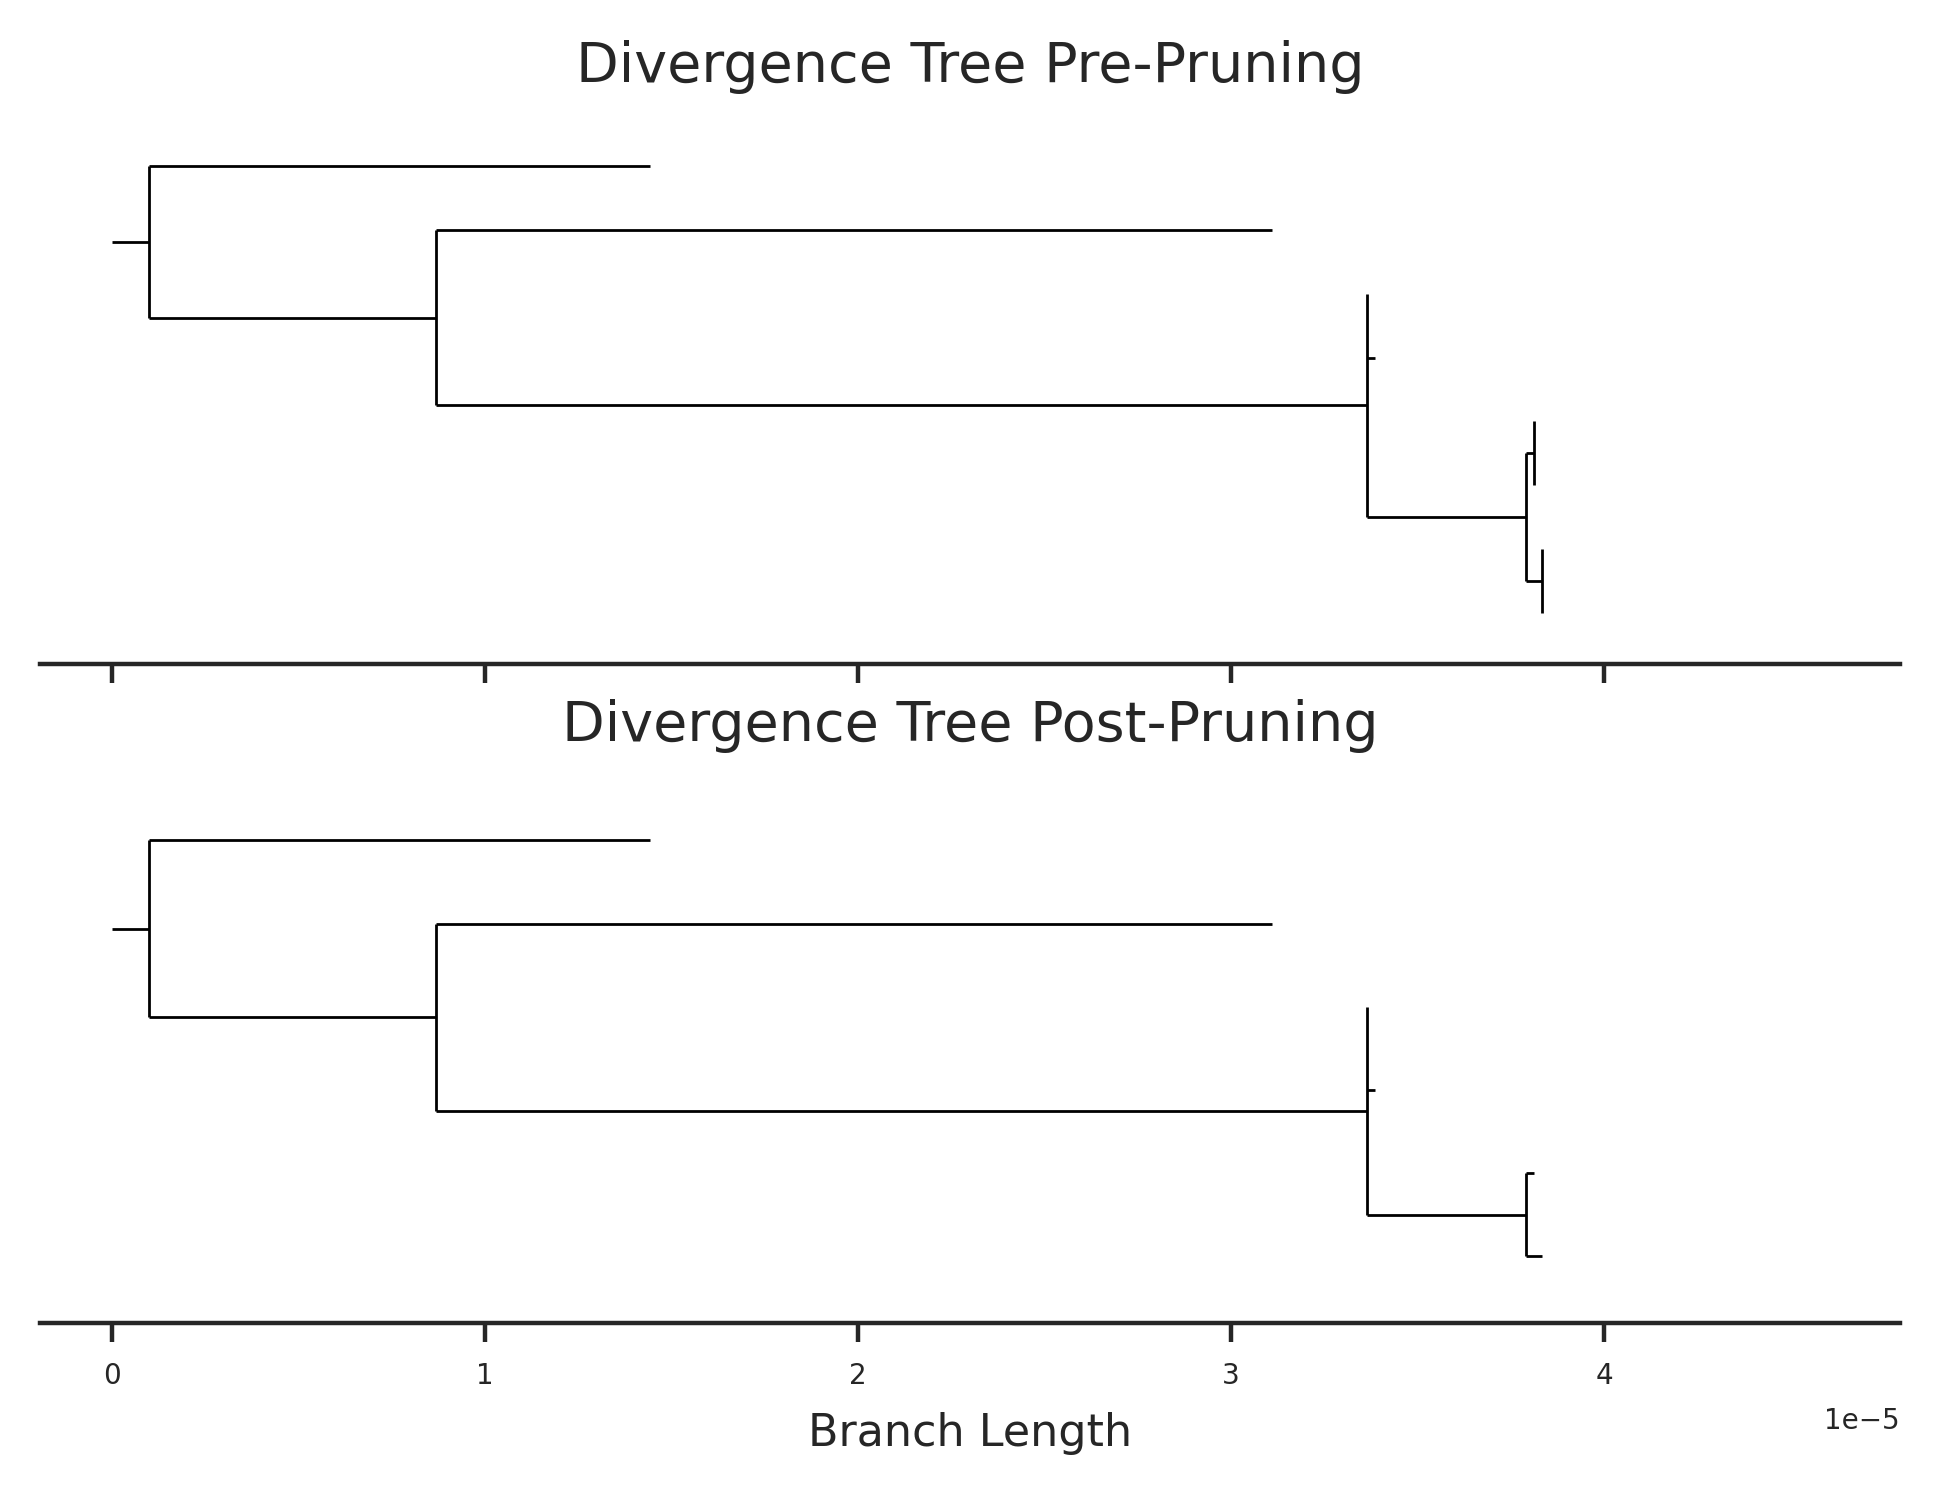

In [15]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]
    
sns.set_style("ticks")  
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)


tt_pre.tree.root.branch_length = 1e-6
tt_prune.tree.root.branch_length = 1e-6
Phylo.draw(tt_pre.tree,   show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax1,)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax2,)

ax1.set_title("Divergence Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Divergence Tree Post-Pruning")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Prune 'Bad' Branches from Time Tree

22.81	--ClockTree.branch_length_to_years: setting node positions in units of
     	  years
22.81	--ClockTree.branch_length_to_years: setting node positions in units of
     	  years
PRUNING: testlocal1
PRUNING: testlocal2


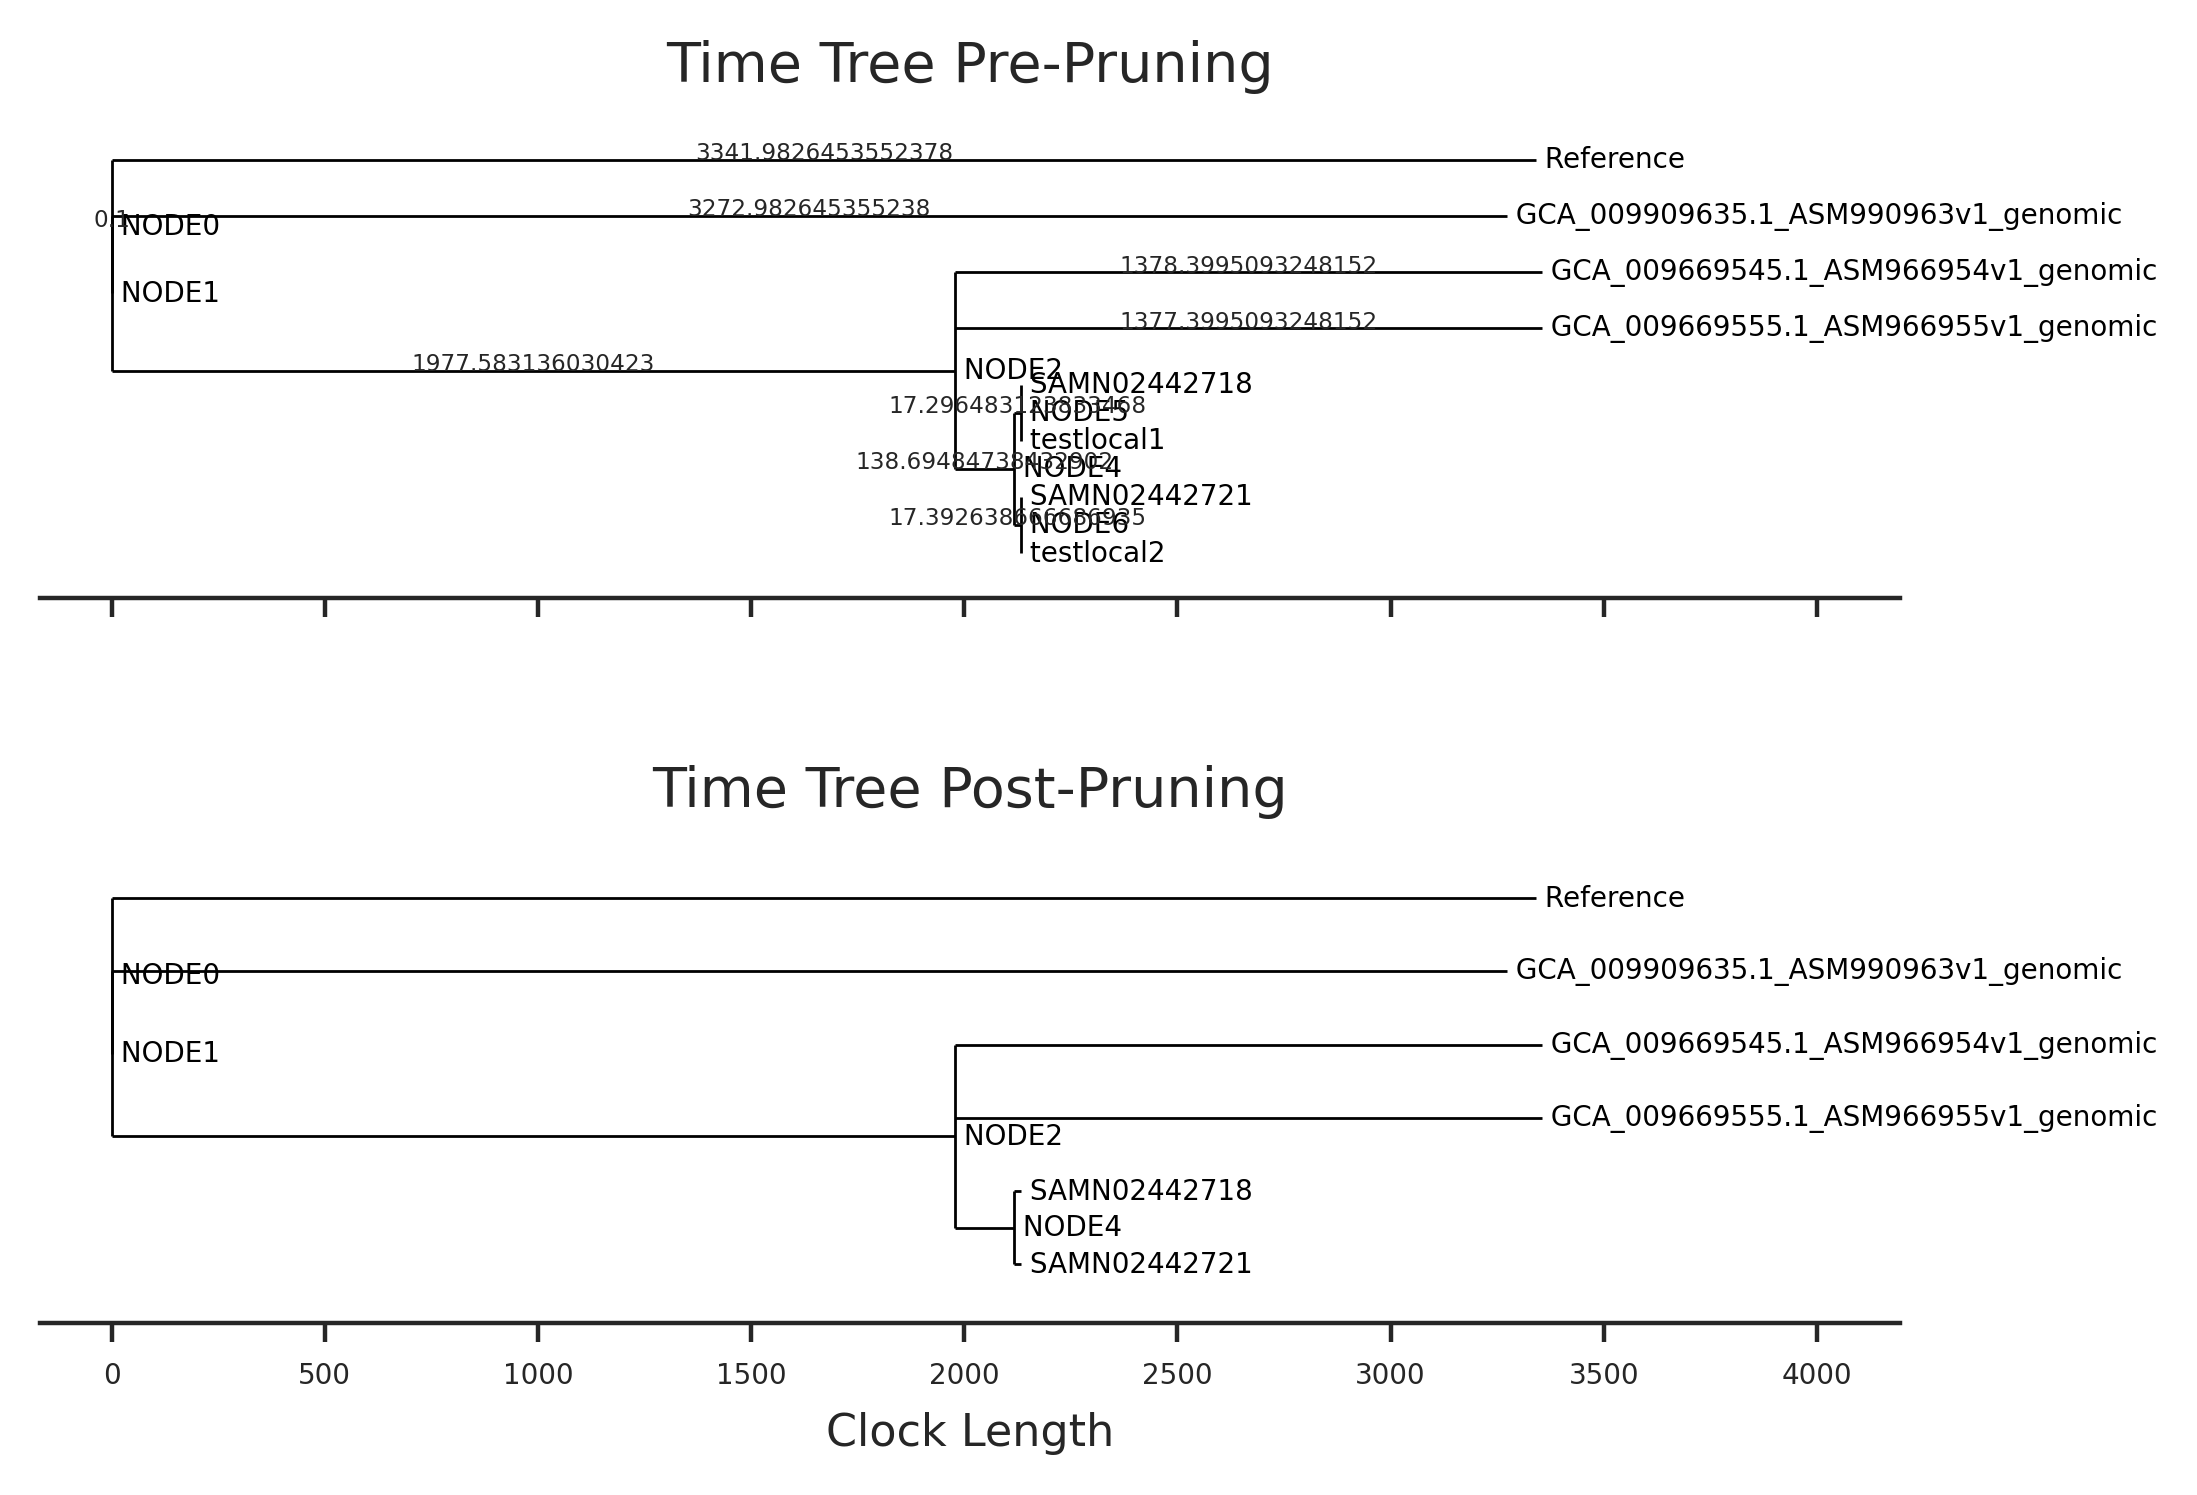

In [16]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

tt_pre.branch_length_to_years()
tt_prune.branch_length_to_years()

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    if n.bad_branch:
        n.color = "red"

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]
    
Phylo.draw(tt_pre.tree,   show_confidence=False, branch_labels = lambda x: x.branch_length, label_func = lambda x: x.name, do_show=False, axes=ax1)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: x.name, do_show=False, axes=ax2)

ax1.set_title("Time Tree Pre-Pruning")
ax2.set_title("Time Tree Post-Pruning")

ax1.set_title("Time Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Time Tree Post-Pruning")
ax2.set_xlabel("Clock Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

fig.subplots_adjust(hspace=0.5)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Update tt variable

In [17]:
tt = tt_prune

## Remove Pruned Nodes from Dataframe

In [18]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,ufboot,scf,branch_length,node_type,coord_x,coord_y,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent
name,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,internal,0.000000,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Reference,NA,NA,1.153650e-05,terminal,0.000012,1.00,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,North America
NODE1,NA,NA,1.153650e-05,internal,0.000012,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,terminal,0.000036,2.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe
NODE2,NA,NA,2.721210e-05,internal,0.000039,5.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,terminal,0.000039,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,terminal,0.000039,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia
NODE4,NA,NA,4.140200e-06,internal,0.000043,6.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMN02442718,NA,NA,2.330000e-08,terminal,0.000043,5.00,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: SRA Ancient,0,Europe


## Remove Pruned Nodes from Alignment

In [19]:
aln = AlignIO.read(aln_path, "fasta")
filtered_seq = [rec for rec in aln if rec.id in tt_nodes]
new_aln = Align.MultipleSeqAlignment(filtered_seq)

---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline
- coord_x and coord_y

## Rates

In [20]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [21]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    tree_df["timetree_num_date_bar"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

CONF_BAD_RANGE = 10000
CONF_EXTREME = 100000
bad_conf = [["node", "lower_bad", "upper_bad", "lower_corrected", "upper_corrected"]]
        
for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE or conf[0] < -CONF_EXTREME or conf[1] > CONF_EXTREME:
            bad_conf.append([c.name, conf[0], conf[1], c.numdate, c.numdate])
            conf[0] = c.numdate
            conf[1] = c.numdate 
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
        # Convert to YBP present for drawing bars
        tree_df.at[c.name, "timetree_num_date_bar"][0] = CURRENT_YEAR - conf[0]
        tree_df.at[c.name, "timetree_num_date_bar"][1] = CURRENT_YEAR - conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length
    
out_path_bad_conf = os.path.join(outdir, SCRIPT_NAME + "_bad-confidence.tsv")
with open(out_path_bad_conf, "w") as outfile:
    for node in bad_conf:
        print("\t".join([str(n) for n in node]))
        outfile.write("\t".join([str(n) for n in node]) + "\n")

24.37	--ClockTree.branch_length_to_years: setting node positions in units of
     	  years
node	lower_bad	upper_bad	lower_corrected	upper_corrected


## RTT

In [22]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

24.52	--ClockTree.branch_length_to_years: setting node positions in units of
     	  years


,ufboot,scf,branch_length,node_type,coord_x,coord_y,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,internal,0.000000,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-7.496119e-09,1.000000,1.000000e-03,-1350-01-07,-1349.982645,"[-2016.834146576216, -1206.0384891277981]","[4037.834146576216, 3227.038489127798]",0.100000,0.100000,2.0625,-1349.982645,0.000000,False
Reference,NA,NA,1.153650e-05,terminal,0.000012,1.00,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,North America,-3.942889e-09,0.525991,1.344151e-05,1992-01-01,1992.000000,"[1992.0, 1992.0]","[29.0, 29.0]",3341.982645,3342.082645,1.0000,1992.000000,0.000013,False
NODE1,NA,NA,1.153650e-05,internal,0.000012,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-2.485297e-08,3.315445,7.680854e-06,-1350-01-07,-1349.982645,"[-1997.6030300650264, -1200.7023195204474]","[4018.6030300650264, 3221.7023195204474]",0.000000,0.100000,3.1250,-1349.982645,0.000008,False
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,terminal,0.000036,2.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,-6.719164e-09,0.896352,2.240270e-05,1923-01-01,1923.000000,"[1923.0, 1923.0]","[98.0, 98.0]",3272.982645,3273.082645,2.0000,1923.000000,0.000030,False
NODE2,NA,NA,2.721210e-05,internal,0.000039,5.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.226834e-08,1.636625,2.496296e-05,0627-08-08,627.600491,"[416.03247952325023, 596.2105055747406]","[1604.9675204767498, 1424.7894944252594]",1977.583136,1977.683136,4.2500,627.600491,0.000033,False
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,terminal,0.000039,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,-7.496119e-10,0.100000,9.309994e-19,2006-01-01,2006.000000,"[2006.0, 2006.0]","[15.0, 15.0]",1378.399509,3356.082645,3.0000,2006.000000,0.000033,False
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,terminal,0.000039,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,-7.496119e-10,0.100000,2.133583e-07,2005-01-01,2005.000000,"[2005.0, 2005.0]","[16.0, 16.0]",1377.399509,3355.082645,4.0000,2005.000000,0.000033,False
NODE4,NA,NA,4.140200e-06,internal,0.000043,6.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-2.695458e-08,3.595804,4.267143e-06,0766-04-18,766.295338,"[643.5012788329993, 759.3073148231886]","[1377.4987211670007, 1261.6926851768114]",138.694847,2116.377983,5.5000,766.295338,0.000037,False
SAMN02442718,NA,NA,2.330000e-08,terminal,0.000043,5.00,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: SRA Ancient,0,Europe,-7.496119e-09,1.000000,9.309831e-19,0783-08-05,783.591821,"[676.435774488305, 800.0]","[1344.564225511695, 1221.0]",0.000000,2116.377983,5.0000,650.000000,0.000037,False


## Divergence coord_x and coord_y

In [23]:
tt_copy = copy.deepcopy(tt)
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)

# Add x and y coordinates as other attributes
for c in tt_copy.tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Update coordinates in dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,ufboot,scf,branch_length,node_type,coord_x,coord_y,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,internal,0.001000,2.0625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-7.496119e-09,1.000000,1.000000e-03,-1350-01-07,-1349.982645,"[-2016.834146576216, -1206.0384891277981]","[4037.834146576216, 3227.038489127798]",0.100000,0.100000,2.0625,-1349.982645,0.000000,False
Reference,NA,NA,1.153650e-05,terminal,0.001013,1.0000,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,North America,-3.942889e-09,0.525991,1.344151e-05,1992-01-01,1992.000000,"[1992.0, 1992.0]","[29.0, 29.0]",3341.982645,3342.082645,1.0000,1992.000000,0.000013,False
NODE1,NA,NA,1.153650e-05,internal,0.001008,3.1250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-2.485297e-08,3.315445,7.680854e-06,-1350-01-07,-1349.982645,"[-1997.6030300650264, -1200.7023195204474]","[4018.6030300650264, 3221.7023195204474]",0.000000,0.100000,3.1250,-1349.982645,0.000008,False
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,terminal,0.001030,2.0000,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,-6.719164e-09,0.896352,2.240270e-05,1923-01-01,1923.000000,"[1923.0, 1923.0]","[98.0, 98.0]",3272.982645,3273.082645,2.0000,1923.000000,0.000030,False
NODE2,NA,NA,2.721210e-05,internal,0.001033,4.2500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.226834e-08,1.636625,2.496296e-05,0627-08-08,627.600491,"[416.03247952325023, 596.2105055747406]","[1604.9675204767498, 1424.7894944252594]",1977.583136,1977.683136,4.2500,627.600491,0.000033,False
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,terminal,0.001033,3.0000,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,-7.496119e-10,0.100000,9.309994e-19,2006-01-01,2006.000000,"[2006.0, 2006.0]","[15.0, 15.0]",1378.399509,3356.082645,3.0000,2006.000000,0.000033,False
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,terminal,0.001033,4.0000,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,-7.496119e-10,0.100000,2.133583e-07,2005-01-01,2005.000000,"[2005.0, 2005.0]","[16.0, 16.0]",1377.399509,3355.082645,4.0000,2005.000000,0.000033,False
NODE4,NA,NA,4.140200e-06,internal,0.001037,5.5000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-2.695458e-08,3.595804,4.267143e-06,0766-04-18,766.295338,"[643.5012788329993, 759.3073148231886]","[1377.4987211670007, 1261.6926851768114]",138.694847,2116.377983,5.5000,766.295338,0.000037,False
SAMN02442718,NA,NA,2.330000e-08,terminal,0.001037,5.0000,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: SRA Ancient,0,Europe,-7.496119e-09,1.000000,9.309831e-19,0783-08-05,783.591821,"[676.435774488305, 800.0]","[1344.564225511695, 1221.0]",0.000000,2116.377983,5.0000,650.000000,0.000037,False


## Add Metadata as Comments

In [24]:
metadata_to_comment(tt.tree, tree_df)

---
# Export

## GTR Model

In [25]:
out_path_gtr = os.path.join(outdir, SCRIPT_NAME + "_gtr.txt" )
gtr_model_str = str(tt.gtr)
with open(out_path_gtr,"w") as outfile:
    outfile.write(gtr_model_str)

## Alignment

In [26]:
out_path_aln = os.path.join(outdir, SCRIPT_NAME + ".fasta" )
with open(out_path_aln, "w") as outfile:
    count = SeqIO.write(new_aln, outfile, "fasta")
    print(count, "alignments written.")

6 alignments written.


## Dataframe

In [27]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [28]:
tt_copy = copy.deepcopy(tt)

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))


1

## Divtrees

In [29]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [30]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "branch_number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    try:
        skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
        augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]
    except TypeError:
        pass

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.15365e-05, 'node_type': 'terminal', 'strain': 'CO92', 'date': 1992.0, 'date_bp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample_accession': 'NA', 'biosample_comment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'continent': 'North America', 'rate': -3.942889282192162e-09, 'rate_fold_change': 0.5259907263070821, 'mutation_length': 1.3441508274911538e-05, 'raw_date': '1992-01-01', 'num_date': 1991.9999999999998, 'num_date_confidence': [1992.0, 1992.0], 'num_date_bar': '29.0:29.0', 'clock_length': 3341.9826453552378}


## Auspice JSON

In [31]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
#out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
#utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
#export_v2.validate_data_json(out_path_auspice_remote_json)
#print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome/filter50/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome/filter50/clock_model_auspice.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.


## BEAST

### Nexus

Without comment, internal nodes names.

In [32]:
# Timetree
tt_copy = copy.deepcopy(tt)
MIN_BRANCH_LENGTH = tt_copy.tree.root.branch_length

# Fix comments and internal nodes names
for c in tt_copy.tree.find_clades(): 
    # Remove comments
    c.comment = None
    # Remove internal node names
    if "NODE" in c.name:
        c.name = None

out_path_beast_time = os.path.join(outdir, SCRIPT_NAME + "_beast_timetree.nex" )
Phylo.write(tt_copy.tree, out_path_beast_time, 'nexus')

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1